#### The Spotify Effect
##### Acevedo, Contreras y Razmilic (2024)

C:\Users\raimu\AppData\Local\Temp\ipykernel_39396\1851635658.py:23: DtypeWarning: Columns (32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_spotify_work = pd.read_csv(spotify_work_path)  # Only if needed
C:\Users\raimu\AppData\Local\Temp\ipykernel_39396\1851635658.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['popularity_log_zscore'].fillna(0, inplace=True)
100%|██████████| 178200/178200 [00:00<00:00, 1

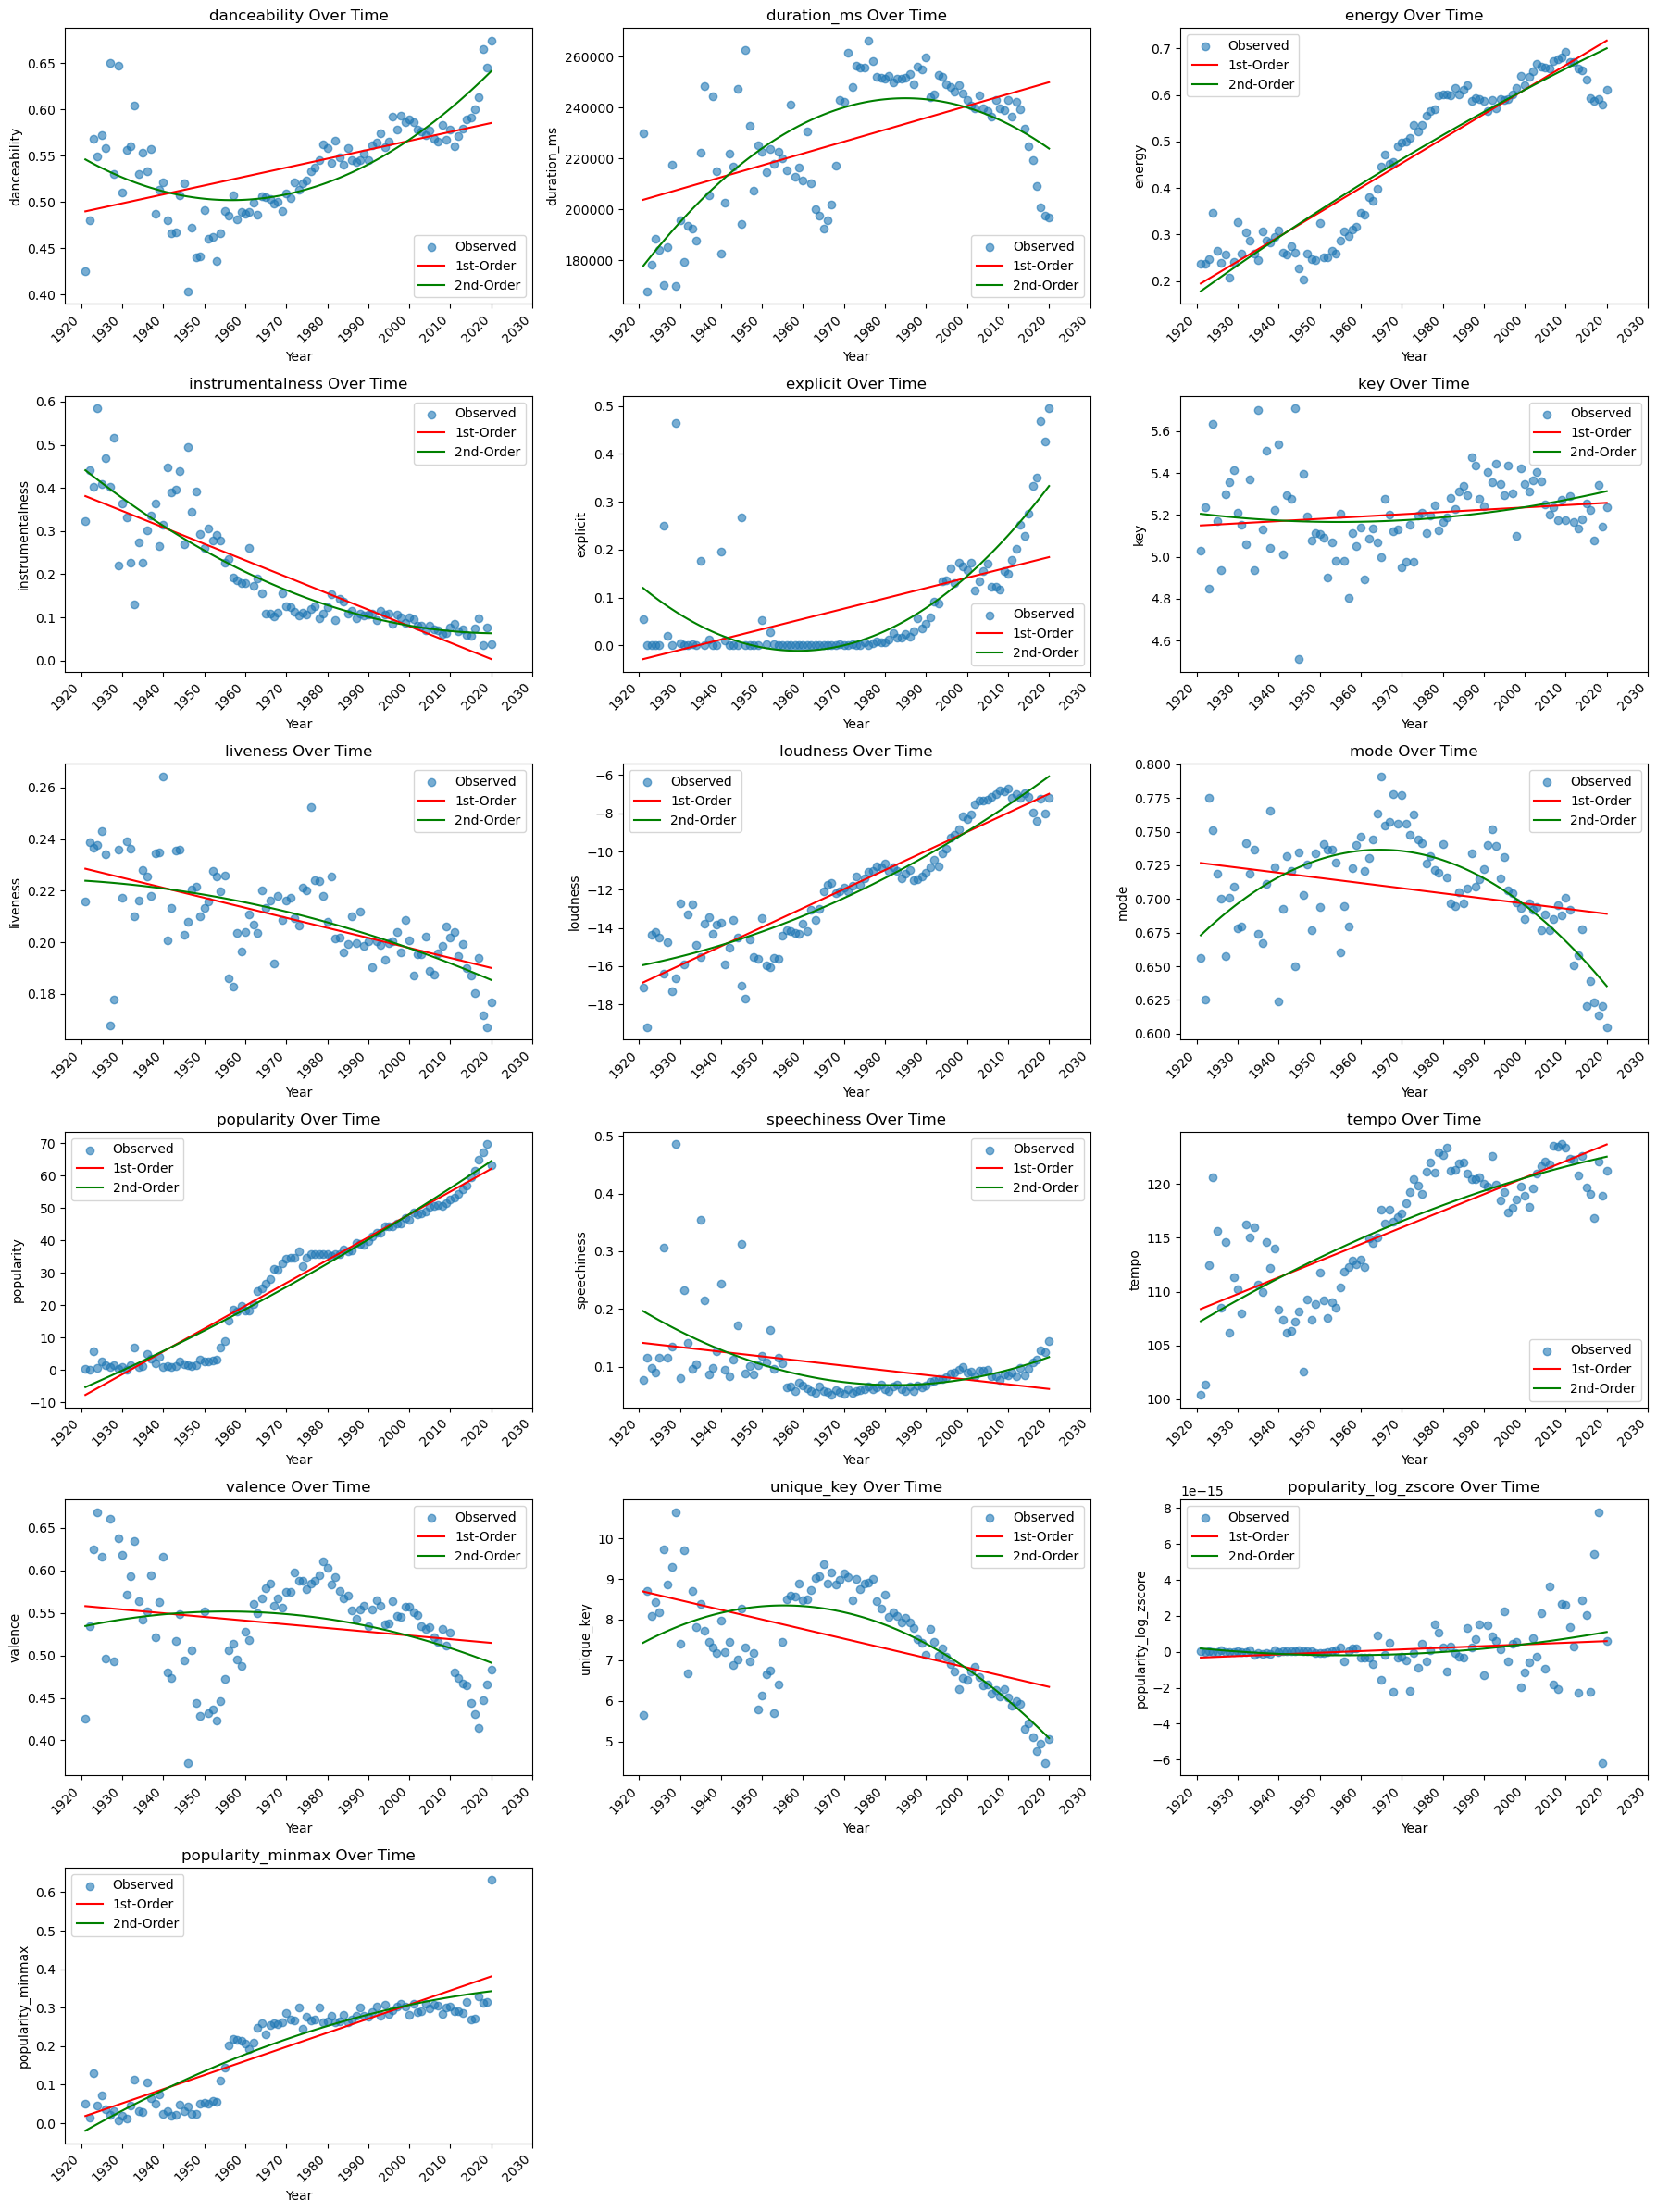

Top 10 Most Used Genres (with 'rock' grouped):
genres_combined
rock                 23682
blues                 2706
singer-songwriter     1779
soul                  1728
mellow gold           1678
jazz                  1596
pop                   1436
rap                   1292
hip hop               1276
classical             1068
Name: count, dtype: int64


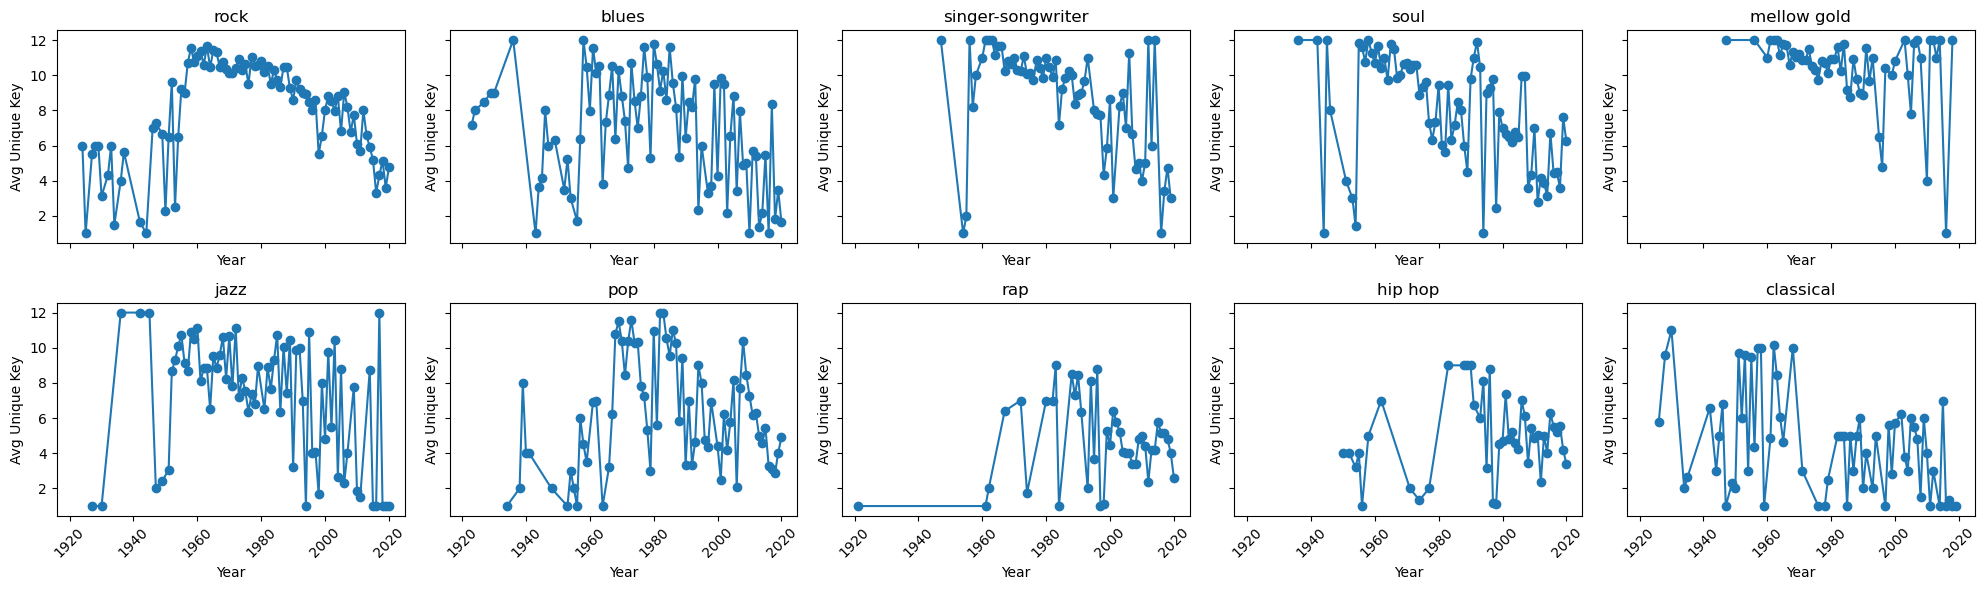

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from rapidfuzz import process, fuzz
from tqdm import tqdm

# Enable progress_apply for pandas.
tqdm.pandas()

# -----------------------------------------------------------------------------
# 1) Define file paths and read the CSV files into DataFrames
# -----------------------------------------------------------------------------
artist_metadata_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\artist_metadata.csv"
spotify_data_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\spotify.csv"
spotify_work_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\spotify_work.csv"  # if needed later
artist_info_path = r"C:\Users\raimu\Dropbox\TSE\Data\spotify\CLEANED_Spotify_artist_info.csv"  # official metadata for genres

# Read CSV data
df_metadata = pd.read_csv(artist_metadata_path)
df_spotify = pd.read_csv(spotify_data_path)
df_spotify_work = pd.read_csv(spotify_work_path)  # Only if needed
df_artist_info = pd.read_csv(artist_info_path)

# -----------------------------------------------------------------------------
# 2) Clean the 'artists' column in df_spotify
# -----------------------------------------------------------------------------
# Remove square brackets and single quotes, then strip extra whitespace.
df_spotify['artists'] = df_spotify['artists'].astype(str)
df_spotify['artists'] = df_spotify['artists'].str.replace(r"[\[\]']", "", regex=True).str.strip()

# -----------------------------------------------------------------------------
# 3) Rename 'artist' to 'artists' in the metadata, then merge
# -----------------------------------------------------------------------------
df_metadata.rename(columns={'artist': 'artists'}, inplace=True)
df_merged = pd.merge(df_spotify, df_metadata, how='outer', on='artists')

# -----------------------------------------------------------------------------
# 4) Calculate unique count of 'key' by 'artists'
# -----------------------------------------------------------------------------
df_merged['unique_key'] = df_merged.groupby('artists')['key'].transform('nunique')

# -----------------------------------------------------------------------------
# 5) Normalize popularity:
#    Apply a logarithmic transformation followed by z-score normalization within each year
# -----------------------------------------------------------------------------
df_merged['popularity_log'] = np.log(df_merged['popularity'] + 1)
df_merged['popularity_log_zscore'] = df_merged.groupby('year')['popularity_log']\
    .transform(lambda x: (x - x.mean()) / x.std())
df_merged['popularity_log_zscore'].fillna(0, inplace=True)

# -----------------------------------------------------------------------------
# 6) Optionally, standardize 'popularity' using min-max scaling within each year
# -----------------------------------------------------------------------------
df_merged['popularity_minmax'] = df_merged.groupby('year')['popularity']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0)

# -----------------------------------------------------------------------------
# 7) Collapse (group) by 'year' and compute mean for selected columns
# -----------------------------------------------------------------------------
collapse_cols = [
    'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'explicit', 'key', 'liveness', 'loudness', 'mode',
    'popularity', 'speechiness', 'tempo', 'valence', 'unique_key',
    'popularity_log_zscore', 'popularity_minmax'
]

df_collapse = (
    df_merged
    .groupby('year', as_index=False)[collapse_cols]
    .mean(numeric_only=True)
)

# -----------------------------------------------------------------------------
# 8) Fuzzy Matching to Obtain Genre Information using RapidFuzz
# -----------------------------------------------------------------------------
# The official artist info dataset has artist names in the 'names' column and
# associated genres in the 'genres' column.

# Clean artist names in the official metadata.
df_artist_info['artist_clean'] = df_artist_info['names'].astype(str).str.lower().str.strip()
# Sort the official artist info DataFrame alphabetically by the cleaned artist names.
df_artist_info.sort_values('artist_clean', inplace=True)

# Clean artist names in df_merged.
df_merged['artist_clean'] = df_merged['artists'].astype(str).str.lower().str.strip()

# ----- Step A: Precompute a Mapping for Unique Artist Names -----
unique_artists = df_merged['artist_clean'].unique().tolist()
choices = df_artist_info['artist_clean'].unique().tolist()
score_cutoff = 80

# Use RapidFuzz's vectorized cdist to compute similarity scores.
scores = process.cdist(unique_artists, choices, scorer=fuzz.token_sort_ratio,
                       score_cutoff=score_cutoff, workers=-1)
scores = np.array(scores)  # Ensure a numpy array

# For each unique artist, pick the candidate with the highest score.
best_indices = np.argmax(scores, axis=1)
best_scores = np.max(scores, axis=1)
artist_mapping = {
    artist: (choices[best_indices[i]] if best_scores[i] >= score_cutoff else None)
    for i, artist in enumerate(unique_artists)
}

# ----- Step B: Handle Multiple Artists in a Single Record -----
def multi_match_artists(artist_str, mapping, separator=','):
    """
    Splits the artist string by the separator, maps each to its best match,
    and returns a comma-separated string of matched names (without duplicates).
    """
    artists = [a.strip() for a in artist_str.split(separator)]
    matched = [mapping.get(a, None) for a in artists if mapping.get(a, None)]
    return ', '.join(sorted(set(matched))) if matched else None

df_merged['matched_artist'] = df_merged['artist_clean'].apply(lambda x: multi_match_artists(x, artist_mapping))

# ----- Step C: Merge Genre Information -----
# Create a dictionary mapping from official cleaned artist names to their genres.
genre_mapping = dict(zip(df_artist_info['artist_clean'], df_artist_info['genres']))

def combine_genres(matched_artists, genre_mapping, separator=','):
    """
    Given a string of matched artist names (separated by commas),
    return a combined string of their genres (also comma-separated).
    Ensures that each genre is a string.
    """
    if pd.isnull(matched_artists):
        return None
    artist_list = [a.strip() for a in matched_artists.split(separator)]
    genres = []
    for a in artist_list:
        g = genre_mapping.get(a, None)
        # Ensure the genre is a valid string.
        if pd.notnull(g):
            g_str = str(g)
            if g_str.lower() != 'nan' and g_str != '':
                genres.append(g_str)
    genres = sorted(set(genres))
    return ', '.join(genres) if genres else None

# Use progress_apply for the combine_genres step.
df_merged['genres_combined'] = df_merged['matched_artist'].progress_apply(lambda x: combine_genres(x, genre_mapping))

# -----------------------------------------------------------------------------
# 9) Prepare for Plotting: Fit Regressions and Create Subplots
# -----------------------------------------------------------------------------
variables_to_plot = collapse_cols
df_collapse['year'] = pd.to_numeric(df_collapse['year'], errors='coerce')
df_collapse.dropna(subset=['year'], inplace=True)
df_collapse.sort_values('year', inplace=True)
X = df_collapse[['year']].values

num_vars = len(variables_to_plot)
ncols = 3
nrows = int(np.ceil(num_vars / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows), sharex=False)
axes = axes.flatten()

tick_interval = 10
min_year = int(df_collapse['year'].min())
max_year = int(df_collapse['year'].max()) + 1
tick_years = range(min_year - (min_year % tick_interval), max_year + tick_interval, tick_interval)

for i, var in enumerate(variables_to_plot):
    if i >= len(axes):
        print(f"Warning: More variables ({len(variables_to_plot)}) than subplots ({len(axes)}).")
        break
    
    ax = axes[i]
    y = df_collapse[var].values

    # 1st-Order (Linear) Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    y_pred_linear = lin_reg.predict(X)

    # 2nd-Order (Quadratic) Regression
    poly_features = PolynomialFeatures(degree=2)
    X_poly = poly_features.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)
    y_pred_poly = poly_reg.predict(X_poly)

    ax.scatter(df_collapse['year'], y, label='Observed', alpha=0.6)
    ax.plot(df_collapse['year'], y_pred_linear, color='red', label='1st-Order')
    ax.plot(df_collapse['year'], y_pred_poly, color='green', label='2nd-Order')

    ax.set_title(f"{var} Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel(var)
    ax.legend()
    ax.set_xticks(tick_years)
    ax.set_xticklabels([str(year) for year in tick_years], rotation=45, ha='right')

for j in range(len(variables_to_plot), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Extract and Clean Genres ---
# Assuming df_merged exists and has columns: 'genres_combined', 'unique_key', and 'year'
all_genres = (
    df_merged['genres_combined']
    .dropna()
    .str.split(',')
    .explode()
    .str.strip()
)

# --- Step 2: Reclassify Genres Containing "rock" ---
def classify_rock(genre):
    if 'rock' in genre.lower():
        return 'rock'
    return genre

all_genres = all_genres.apply(classify_rock)

# --- Step 3: Count Frequency and Get Top 10 Genres ---
top_10_genres = all_genres.value_counts().head(10)
print("Top 10 Most Used Genres (with 'rock' grouped):")
print(top_10_genres)
top10_list = top_10_genres.index.tolist()

# --- Step 4: Prepare Data for Grouping by Year and Genre ---
# Create a temporary DataFrame with needed columns and ensure 'year' is numeric.
df_temp = df_merged[['year', 'genres_combined', 'unique_key']].dropna(subset=['genres_combined']).copy()
df_temp['year'] = pd.to_numeric(df_temp['year'], errors='coerce')
df_temp = df_temp.dropna(subset=['year'])

# Split the 'genres_combined' column into separate rows.
df_temp['genre_list'] = df_temp['genres_combined'].str.split(',')
df_temp = df_temp.explode('genre_list')
df_temp['genre_list'] = df_temp['genre_list'].str.strip()

# Reclassify any genre containing "rock" as "rock"
df_temp['genre_list'] = df_temp['genre_list'].apply(lambda x: 'rock' if 'rock' in x.lower() else x)

# --- Step 5: Group by Year and Genre, Compute Average Unique Key ---
df_grouped = df_temp.groupby(['year', 'genre_list'])['unique_key'].mean().reset_index()
# Filter to only include the top 10 genres.
df_grouped_top10 = df_grouped[df_grouped['genre_list'].isin(top10_list)]

# --- Step 6: Create Subplots for Each Top Genre ---
n = len(top10_list)
ncols = 5  # Adjust number of columns if desired
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*3), sharex=True, sharey=True)
axes = axes.flatten()

for i, genre in enumerate(top10_list):
    genre_data = df_grouped_top10[df_grouped_top10['genre_list'] == genre]
    ax = axes[i]
    ax.plot(genre_data['year'], genre_data['unique_key'], marker='o')
    ax.set_title(genre)
    ax.set_xlabel("Year")
    ax.set_ylabel("Avg Unique Key")
    ax.tick_params(axis='x', rotation=45)

# Hide any extra subplots.
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
